# <center>Implementing SVRG in a state-of-the-art CNN model</center>

The goal of this notebook is to implement SVRG in more complex models - such as CNN with batch normalization - and compare its convergence rate with SGD. 

# I- Preprocessing

##### Import Pytorch and other useful librairies

In [1]:
from matplotlib import pyplot as plt
plt.gray()
import math
import numpy as np
import pandas as pd

import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch import nn
from torch import optim
import copy

##### Define auxiliary functions


In [2]:
loss_func = F.cross_entropy

def accuracy(Y_hat, Y):
    preds = torch.argmax(Y_hat, dim=1)
    return (preds == Y).float().mean()

##### Load and preprocess dataset

In [3]:
#import data
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=None)

#load trainset into tensors
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True)
X_train = train_loader.dataset.data
Y_train = train_loader.dataset.targets

#load testset into tensors
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10000, shuffle=False)
X_test = test_loader.dataset.data
Y_test = test_loader.dataset.targets

#scale data to [0:1] and convert to float32
X_train = (X_train.to(dtype=torch.float32) / X_train.max().to(dtype=torch.float32))
X_test = (X_test.to(dtype=torch.float32) / X_test.max().to(dtype=torch.float32))

print("Train examples : ",X_train.shape[0])
print("Test examples : ",X_test.shape[0])
print("Nb of features : ",X_train.shape[1])

Train examples :  60000
Test examples :  10000
Nb of features :  28


# II- Implementing SVRG on a simple neural network

In [25]:
class SimpleNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784,100)
        self.linear2 = nn.Linear(100,10)
        self.linear1_snapshot = nn.Linear(784,100)
        self.linear2_snapshot = nn.Linear(100,10)
        
        self.number_params = 4 
        
        self.mu = [None] * self.number_params
        
        self.copy_snapshot()
 
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.softmax(self.linear2(x),1)
        return x
    
    def forward_snapshot(self, x):
        x = torch.sigmoid(self.linear1_snapshot(x))
        x = torch.softmax(self.linear2_snapshot(x),1)
        return x
    
    def copy_snapshot(self):
        params = list(self.parameters())
        for i in range(self.number_params):
            params[i+self.number_params].data.copy_(params[i])

        i=0
        for param in self.parameters():
            if (i < self.number_params) :
                self.mu[i] = torch.zeros(param.shape)
                i+=1

    def update_SGD(self, lr=1):
        params = list(self.parameters())
        for i in range(self.number_params):
            params[i].data.copy_(params[i].data - lr * params[i].grad.data)

    def update_SVRG(self,lr):
        params = list(self.parameters())
        for i in range(self.number_params):
            params[i].data.copy_(params[i].data - lr * (params[i].grad.data - params[i+self.number_params].grad.data + self.mu[i].data))       

    def update_mu(self,n,batch_size):
        params = list(self.parameters())
        for i in range(len(self.mu)):
            self.mu[i].data.copy_(self.mu[i].data + params[i+self.number_params].grad.data / (n/batch_size))
                            
    def fit_SVRG(self,optimizer,epochs,warm_epochs,n,batch_size,lr):
        params = list(self.parameters())
        loss_graph = []
        
        n = X_train.shape[0]
        self.train()
        
        #Warm start
        for epoch in range(warm_epochs):
            for i in range((n - 1) // batch_size + 1):
                optimizer.zero_grad()
                X = X_train[ i * batch_size : (i+1) * batch_size ]
                Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                pred = self.forward( X )
                loss = loss_func( pred , Y )
                loss.backward()
                self.update_SGD(0.25)

            loss_graph.append(loss.item())
            print(epoch,"\t",loss.item())

        self.copy_snapshot()
    
        for epoch in range(epochs):
            self.train()
            #update mu
            for i in range((n - 1) // batch_size + 1):
                optimizer.zero_grad()
                X = X_train[ i * batch_size : (i+1) * batch_size ]
                Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                pred = self.forward_snapshot( X )
                loss_snapshot = loss_func( pred , Y )

                loss_snapshot.backward()

                self.update_mu(n,batch_size)
            
            
            for m in range(5):
                for i in range((n - 1) // batch_size + 1):
                    optimizer.zero_grad()
                    
                    #Snapshot gradient computation
                    X = X_train[ i * batch_size : (i+1) * batch_size ]
                    Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                    X = self.forward_snapshot( X )
                    loss_snapshot = loss_func( X , Y )
                    loss_snapshot.backward()
                    #'real' gradient computation
                    X = X_train[ i * batch_size : (i+1) * batch_size ]
                    Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                    X = self.forward( X )
                    loss = loss_func( X , Y )
                    loss.backward()
                    self.update_SVRG(lr)
                
                loss_graph.append(loss.item())
                print(epoch * 5 + m+warm_epochs,"\t",loss.item())
            
            self.copy_snapshot()
            with torch.no_grad():
                self.eval()
                print("Test set \t", round(accuracy( self.forward(X_test.reshape(-1,784)) , Y_test).item(),3))
            
        return loss_graph

    def fit_SGD(self,optimizer,epochs,batch_size,lr):
        loss_graph = []
        n = X_train.shape[0]
       
        for epoch in range(epochs):
            self.train()
            for i in range((n - 1) // batch_size + 1):
                optimizer.zero_grad()
                X = X_train[ i * batch_size : (i+1) * batch_size ]
                Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                pred = self.forward( X )
                loss = loss_func( pred , Y )
                loss.backward()
                self.update_SGD(lr)
            
            loss_graph.append(loss.item())
            print(epoch,"\t",loss.item())

            with torch.no_grad():
                self.eval()
                print("Test set \t", round(accuracy( self.forward(X_test.reshape(-1,784)) , Y_test).item(),3))
            
        return loss_graph

In [33]:
X_train = X_train.reshape(60000,784)
epochs = 9
warm_epochs = 5
batch_size = 60
learning_rate = 0.4

In [34]:
simple_mod = SimpleNet()
opt = optim.SGD(simple_mod.parameters(), lr=10)
loss_SVRG = simple_mod.fit_SVRG(opt,epochs,warm_epochs,X_train.shape[0],batch_size,learning_rate)

0 	 1.9899097681045532
1 	 1.6986184120178223
2 	 1.6377289295196533
3 	 1.6269985437393188
4 	 1.621338963508606
5 	 1.6149697303771973
6 	 1.5586248636245728
7 	 1.5240319967269897
8 	 1.5112348794937134
9 	 1.5015599727630615
Test set 	 0.933
10 	 1.4899380207061768
11 	 1.4854739904403687
12 	 1.4826315641403198
13 	 1.48070228099823
14 	 1.479218602180481
Test set 	 0.943
15 	 1.474609136581421
16 	 1.4734580516815186
17 	 1.47251558303833
18 	 1.4716854095458984
19 	 1.470935583114624
Test set 	 0.95
20 	 1.470125675201416
21 	 1.469614028930664
22 	 1.469159483909607
23 	 1.4687548875808716
24 	 1.4683871269226074
Test set 	 0.956
25 	 1.4680085182189941
26 	 1.4676709175109863
27 	 1.4673434495925903
28 	 1.467032551765442
29 	 1.4667414426803589
Test set 	 0.96
30 	 1.466991662979126
31 	 1.4667099714279175
32 	 1.466439962387085
33 	 1.4661825895309448
34 	 1.4659515619277954
Test set 	 0.963
35 	 1.4661186933517456
36 	 1.465930700302124
37 	 1.465793251991272
38 	 1.4656952

In [30]:
epochs = 50

simple_mod = SimpleNet()
opt = optim.SGD(simple_mod.parameters(), lr=10)
loss_SGD = simple_mod.fit_SGD(opt,epochs,batch_size,0.25)

0 	 1.9338434934616089
Test set 	 0.585
1 	 1.7983834743499756
Test set 	 0.666
2 	 1.7546272277832031
Test set 	 0.734
3 	 1.6593934297561646
Test set 	 0.823
4 	 1.6289886236190796
Test set 	 0.842
5 	 1.5615859031677246
Test set 	 0.905
6 	 1.5392341613769531
Test set 	 0.912
7 	 1.525741457939148
Test set 	 0.919
8 	 1.5156439542770386
Test set 	 0.923
9 	 1.5076459646224976
Test set 	 0.926
10 	 1.5009576082229614
Test set 	 0.928
11 	 1.4952515363693237
Test set 	 0.931
12 	 1.490461826324463
Test set 	 0.933
13 	 1.486564040184021
Test set 	 0.935
14 	 1.4834721088409424
Test set 	 0.937
15 	 1.4810388088226318
Test set 	 0.938
16 	 1.4791264533996582
Test set 	 0.94
17 	 1.4776209592819214
Test set 	 0.942
18 	 1.4764236211776733
Test set 	 0.943
19 	 1.475460410118103
Test set 	 0.944
20 	 1.4746752977371216
Test set 	 0.944
21 	 1.4740196466445923
Test set 	 0.946
22 	 1.4734504222869873
Test set 	 0.947
23 	 1.4729386568069458
Test set 	 0.948
24 	 1.472467064857483
Test set

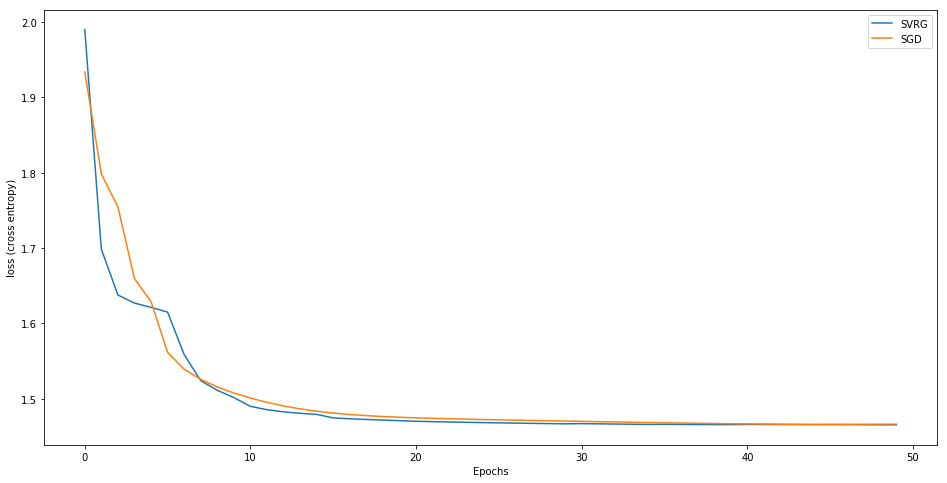

In [35]:
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.xlabel("Epochs")
plt.ylabel("loss (cross entropy)")
plt.plot(loss_SVRG,label = "SVRG")
plt.plot(loss_SGD,label = "SGD")
plt.legend()

##### Define the CNN architecture

In [128]:
class NeuralNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, kernel_size=5, stride=1, padding=2)
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(24, 48, kernel_size=5, stride=1, padding=2)
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=5, stride=1, padding=2)
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        self.linear4 = nn.Linear(64*3*3,256)
        self.bn4 = nn.BatchNorm1d(256)
        self.linear5 = nn.Linear(256,10)
        
        self.conv1_snapshot = nn.Conv2d(1, 24, kernel_size=5, stride=1, padding=2)
        self.max1_snapshot = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1_snapshot = nn.BatchNorm2d(24)
        self.conv2_snapshot = nn.Conv2d(24, 48, kernel_size=5, stride=1, padding=2)
        self.max2_snapshot = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn2_snapshot = nn.BatchNorm2d(48)
        self.conv3_snapshot = nn.Conv2d(48, 64, kernel_size=5, stride=1, padding=2)
        self.max3_snapshot = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn3_snapshot = nn.BatchNorm2d(64)
        self.linear4_snapshot = nn.Linear(64*3*3,256)
        self.bn4_snapshot = nn.BatchNorm1d(256)
        self.linear5_snapshot = nn.Linear(256,10)
        
        self.number_params = 18
        
        self.mu = [None] * self.number_params
        
        self.copy_snapshot()
 
    def forward(self, x):
        #print("--------FORWARD---------")
        x = torch.relu(self.conv1(x))
        #print("conv1 :" , x.shape)
        x = self.max1(x)
        x = self.bn1(x)
        #print("max1 :" , x.shape)
        x = torch.relu(self.conv2(x))
        #print("conv2 :" , x.shape)
        x = self.max2(x)
        x = self.bn2(x)
        #print("max2 :" , x.shape)
        x = torch.relu(self.conv3(x))
        #print("conv3 :" , x.shape)
        x = self.max3(x)
        x = self.bn3(x)
        #print("max3 :" , x.shape)
        x = torch.relu(self.linear4(x.reshape(x.shape[0],-1)))
        #print("linear4 :" , x.shape)
        x = self.bn4(x)
        x = torch.softmax(self.linear5(x),1)
        #print("linear5 :" , x.shape)
        return x
    
    def forward_snapshot(self, x):
        #print("--------FORWARD---------")
        x = torch.relu(self.conv1_snapshot(x))
        #print("conv1 :" , x.shape)
        x = self.max1(x)
        x = self.bn1_snapshot(x)
        #print("max1 :" , x.shape)
        x = torch.relu(self.conv2_snapshot(x))
        #print("conv2 :" , x.shape)
        x = self.max2(x)
        x = self.bn2_snapshot(x)
        #print("max2 :" , x.shape)
        x = torch.relu(self.conv3_snapshot(x))
        #print("conv3 :" , x.shape)
        x = self.max3(x)
        x = self.bn3_snapshot(x)
        #print("max3 :" , x.shape)
        x = torch.relu(self.linear4_snapshot(x.reshape(x.shape[0],-1)))
        #print("linear4 :" , x.shape)
        x = self.bn4_snapshot(x)
        x = torch.softmax(self.linear5_snapshot(x),1)
        #print("linear5 :" , x.shape)
        return x
    
    def copy_snapshot(self):
        params = list(self.parameters())
        for i in range(self.number_params):
            params[i+self.number_params].data.copy_(params[i])
        i=0
        for param in self.parameters():
            if (i < self.number_params) :
                self.mu[i] = torch.zeros(param.shape)
                i+=1

    def update_SGD(self, lr=1):
        params = list(self.parameters())
        for i in range(self.number_params):
            params[i].data.copy_(params[i].data - lr * params[i].grad.data)

    def update_SVRG(self,lr):
        params = list(self.parameters())
        for i in range(self.number_params):
            params[i].data.copy_(params[i].data - lr * (params[i].grad.data - params[i+self.number_params].grad.data + self.mu[i].data))       

    def update_mu(self,n,batch_size):
        params = list(self.parameters())
        for i in range(len(self.mu)):
            self.mu[i].data.copy_(self.mu[i].data + params[i+self.number_params].grad.data / (n/batch_size))
                            
    def fit_SVRG(self,optimizer,epochs,warm_epochs,n,batch_size,lr):
        params = list(self.parameters())
        
        n = X_train.shape[0]
        self.train()
        
        #Warm start
        for epoch in range(warm_epochs):
            for i in range((n - 1) // batch_size + 1):
                optimizer.zero_grad()
                X = X_train[ i * batch_size : (i+1) * batch_size ]
                Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                pred = self.forward( X )
                loss = loss_func( pred , Y )
                loss.backward()
                self.update_SGD(0.1)
                
            print(epoch,"\t",loss.item())

        self.copy_snapshot()
    
        for epoch in range(epochs):
            self.train()
            #update mu
            for i in range((n - 1) // batch_size + 1):
                optimizer.zero_grad()
                X = X_train[ i * batch_size : (i+1) * batch_size ]
                Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                pred = self.forward_snapshot( X )
                loss_snapshot = loss_func( pred , Y )

                loss_snapshot.backward()

                self.update_mu(n,batch_size)
            
            
            for m in range(5):
                for i in range((n - 1) // batch_size + 1):
                    optimizer.zero_grad()
                    
                    #Snapshot gradient computation
                    X = X_train[ i * batch_size : (i+1) * batch_size ]
                    Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                    X = self.forward_snapshot( X )
                    loss_snapshot = loss_func( X , Y )
                    loss_snapshot.backward()
                    #'real' gradient computation
                    X = X_train[ i * batch_size : (i+1) * batch_size ]
                    Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                    X = self.forward( X )
                    loss = loss_func( X , Y )
                    loss.backward()
                    self.update_SVRG(lr)
                    
                print(epoch * 5 + m +warm_epochs,"\t",loss.item())
            
            self.copy_snapshot()
            with torch.no_grad():
                self.eval()
                print("Test set \t", round(accuracy( self.forward( X_test ) , Y_test).item(),3))

    def fit_SGD(self,optimizer,epochs,batch_size,lr):
        n = X_train.shape[0]
       
        for epoch in range(epochs):
            self.train()
            for i in range((n - 1) // batch_size + 1):
                optimizer.zero_grad()
                X = X_train[ i * batch_size : (i+1) * batch_size ]
                Y = Y_train[ i * batch_size : (i+1) * batch_size ]
                pred = self.forward( X )
                loss = loss_func( pred , Y )
                loss.backward()
                self.update_SGD(lr)
                
            print(epoch,"\t",loss.item())

            with torch.no_grad():
                self.eval()
                print("Test set \t", round(accuracy( self.forward( X_test ) , Y_test).item(),3))

In [133]:
#Flatten train and test data
X_train = X_train.reshape(X_train.shape[0],1,28,28)
X_test = X_test.reshape(X_test.shape[0],1,28,28)

model = NeuralNet()
opt = optim.SGD(model.parameters(), lr=10)
epochs = 5
warm_epochs = 0
batch_size = 600
learning_rate = 0.25

model.fit_SVRG(opt,epochs,warm_epochs,X_train.shape[0],batch_size,learning_rate)

0 	 1.782957911491394
1 	 1.5898760557174683
2 	 1.5451345443725586
3 	 1.5209664106369019
4 	 1.5085258483886719
Test set 	 0.954
5 	 1.4949973821640015
6 	 1.4894193410873413
7 	 1.485562801361084
8 	 1.4824090003967285
9 	 1.4801219701766968
Test set 	 0.98
10 	 1.4785144329071045
11 	 1.4771745204925537
12 	 1.4759944677352905
13 	 1.474901556968689
14 	 1.473824143409729
Test set 	 0.981
15 	 1.472571849822998
16 	 1.4717108011245728
17 	 1.4711642265319824
18 	 1.470638632774353
19 	 1.470239520072937
Test set 	 0.981
20 	 1.4698774814605713
21 	 1.46943998336792
22 	 1.4688915014266968
23 	 1.468032717704773
24 	 1.467490792274475
Test set 	 0.982


###### Load, Preprocess and predict test set from Kaggle

In [104]:
#Load data from CSV
test = pd.read_csv('../data/MNIST/test.csv')
test_tensor = torch.tensor(test.values)

#Preprocess
test_tensor = (test_tensor.to(dtype=torch.float32) / test_tensor.max().to(dtype=torch.float32))
test_tensor = test_tensor.reshape(test_tensor.shape[0],1,28,28)

#Predict
test_tensor = model.forward(test_tensor)
test_tensor = test_tensor.argmax(1)

##### Save predictions to a csv file

In [19]:
#Convert to a numpy array
arr = test_tensor.numpy()

# write CSV
np.savetxt('../data/MNIST/predictions.csv', arr)

NameError: name 'test_tensor' is not defined